# Introduction

The gym chain Model Fitness is developing a customer interaction strategy based on analytical data. 
One of the most common problems gyms and other services face is customer churn. How do you know if a customer is no longer with you? You can calculate churn based on people who get rid of their accounts or don't renew their contracts.\
For a gym, it makes sense to say a customer has left if they don't come for a month. Of course, it's possible they're in Cancun and will resume their visits when they return, but's that's not a typical case. Usually, if a customer joins, comes a few times, then disappears, they're unlikely to come back.\
In order to fight churn, Model Fitness has digitized a number of its customer profiles.

**My task** is to analyze them and come up with a customer retention strategy.

In [1]:
# at first, Loading all the libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import silhouette_score
#from sklearn.metrics import roc_curve
from scipy.cluster.hierarchy import dendrogram, linkage

# Step 1. Download the data

In [2]:
# Load the data file into a DataFrame
path_h = "/Users/victo/Downloads/gym_churn_us.csv"
path = '/datasets/gym_churn_us.csv'

try:
    gym_churn = pd.read_csv(path_h, sep = ',')
except:
    gym_churn = pd.read_csv(path, sep = ',')

# let's see what we have    
gym_churn.sample(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3053,0,1,0,0,1,1,1,33,213.817861,1.0,3,2.481536,2.549402,0
2225,0,1,0,0,1,12,1,33,54.600545,11.0,1,0.213186,0.099015,0
1986,0,1,1,0,1,12,1,29,109.301179,12.0,0,2.830390,2.986225,0
592,1,0,1,0,0,1,1,28,213.481837,1.0,1,1.672709,1.005976,1
2817,1,1,1,1,1,1,0,28,220.803419,1.0,10,2.996507,3.111245,0


Ok, we got the dataset includes the following fields:

'Churn' — the fact of churn for the month in question

Current dataset fields:

User data for the preceding month
- 'gender'- gender of the client without the description of values, so I applied that 1 is a male, and 0 is a female (yep, it's slightly sexist). But it **needs confirmation** from the data owner.
- 'Near_Location' — whether the user lives or works in the neighborhood where the gym is located
- 'Partner' — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
- 'Promo_friends' — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
- 'Phone' — whether the user provided their phone number
- 'Age' - age of the client
- 'Lifetime' — the time (in months) since the customer first came to the gym

Data from the log of visits and purchases and data on current membership status
- 'Contract_period' — 1 month, 3 months, 6 months, or 1 year
- 'Month_to_end_contract' — the months remaining until the contract expires
- 'Group_visits' — whether the user takes part in group sessions
- 'Avg_class_frequency_total' — average frequency of visits per week over the customer's lifetime
- 'Avg_class_frequency_current_month' — average frequency of visits per week over the preceding month
- 'Avg_additional_charges_total' — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.

# Step 2. Carry out exploratory data analysis (EDA)

In [3]:
# let's take the statistics of data
gym_churn.info(memory_usage ='deep')
print()
gym_churn.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


So what we have:\
The data has 4000 rows and 14 features and hasn't missing values. I also don't see the wrong data type for the values.\
We have almost equal numbers of male and female clients aged from 18 to 41 years (average 29 years). The overwhelming number of clients either live or work in the same area as the club (considering that the establishment is a chain - it may have many branches), and almost half are employees of partner companies.\
A little less than a third of clients used a friend’s promotional code, but the fact that 90% left their phone number indicates that they are committed to communicating and possibly participating in promotions.\
The most popular contracts are for 1 month, but on average clients visit the gym for 3 - 4 months before disappearing.\
Every 4th person stops coming, and the churn is 26.53%

And now, let's come back to the exploration of our data.

In [4]:
# firstly, let's change all capital letters to lowercase in the column's names.
# It's not necessary, I just like this format
gym_churn.columns = gym_churn.columns.str.lower()

# checking for duplicates in the data
print(f'The number of duplicates is: {gym_churn.duplicated().sum()}')

# let's look at the data already
print()
gym_churn.sample(5)

The number of duplicates is: 0



,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
3314,0,0,0,0,1,1,0,26,38.570305,1.0,0,2.899157,2.931733,1
1601,1,0,1,0,1,1,0,31,288.739684,1.0,0,2.032659,2.175619,0
2905,0,1,0,0,1,1,0,28,37.990536,1.0,1,0.518081,0.000000,1
2132,1,1,0,0,0,1,0,25,62.306445,1.0,0,2.131532,2.109236,1
3816,0,1,1,1,1,1,0,29,311.133960,1.0,6,0.646809,0.618610,0


So, there are no missing data, and there are no duplicates either.\
!But\
The lack of client ID raises questions. Well, this data is not needed for prediction, and will even create “noise” (they would have filtered it from the set anyway). But how to work with data after clustering if it is impossible to understand which client belongs to which cluster?\
Perhaps the employee who collected this dataset received an inaccurate technical assignment and removed everything that he considered not relevant, or this was an error on his part.\
I would request a new dataset at this stage.

In the meantime, let's continue to explore the data. Let's look at the average values of variables in the context of clients who left and those who remained.

In [5]:
# let's get the table
gym_churn.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


OK. We see that generalized customers who have gone and remained, have two variables with similar values: gender and phone. (If the values are so similar - how do they affect the quality of the prediction? Maybe it is worth filtering them?).\
As it were, we see that the risk group includes: young people, on average 27 years old, visiting the gym 1-2 times a week (more often 1), concluding a contract for a month, and they just end in their second contract.

Now let's take a look at the distribution of the values of these variables.

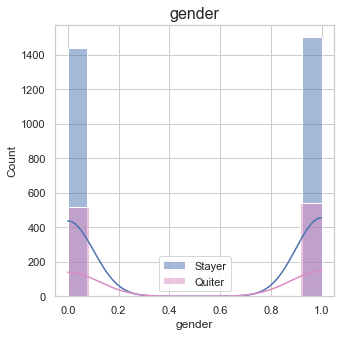

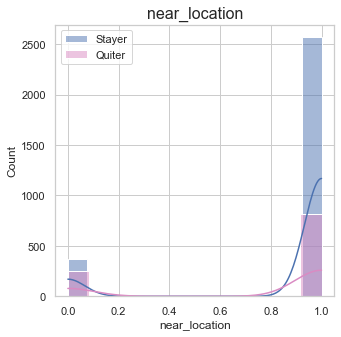

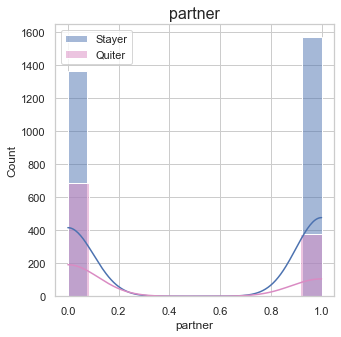

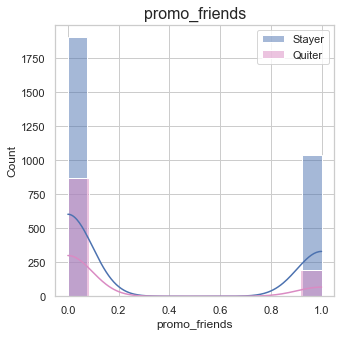

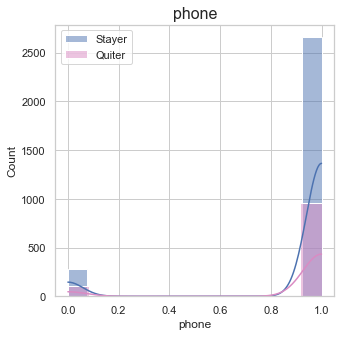

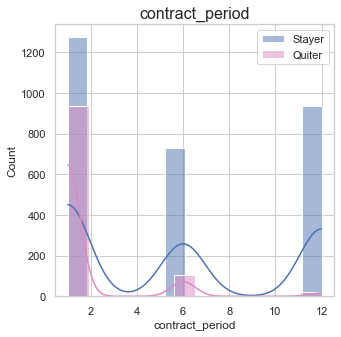

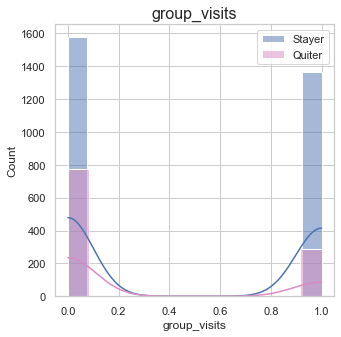

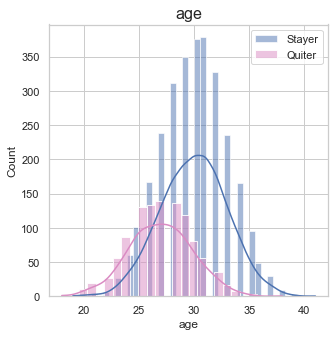

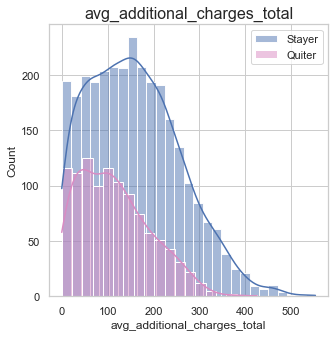

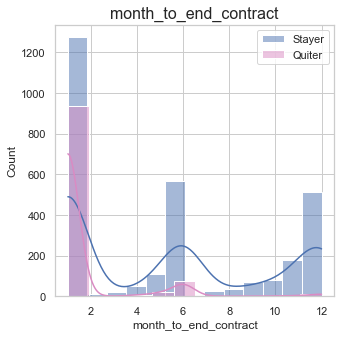

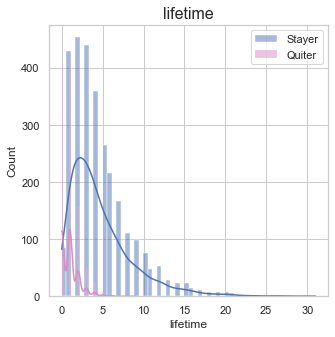

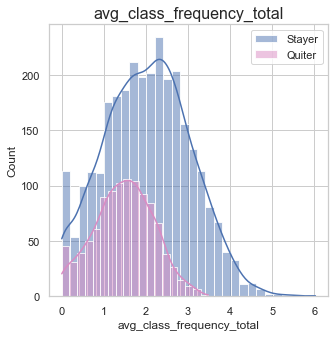

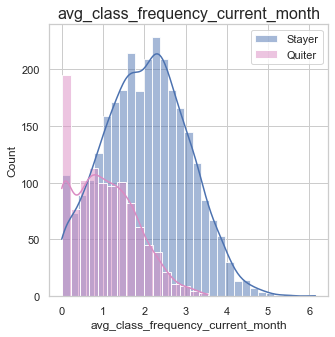

In [6]:
# divide the data into two sets on the basis of churn/not churn
gym_churn_st = gym_churn.loc[gym_churn.churn == 0]
gym_churn_qu = gym_churn.loc[gym_churn.churn == 1]

# we build charts with distribution by all features
sns.set(style="whitegrid")
colors = sns.color_palette("deep")
for col in gym_churn.drop('churn', axis = 1).columns:
    plt.figure(figsize=(5, 5))
    sns.histplot(gym_churn_st[col], color=colors[0], kde=True, label = 'Stayer')
    sns.histplot(gym_churn_qu[col], color=colors[6], kde=True, label = 'Quiter')
    plt.title(col, fontsize = 16)
    plt.legend()
    plt.show()
plt.close('all');

From the distribution, we see that more often clients leave who do not live or work in the area, who did not come through an affiliate program, who do not use promotions from friends, or with a short-term contract. In addition, they are much less likely to attend not only group classes, but also the gym as a whole.

Now, let's look at the correlation matrix.

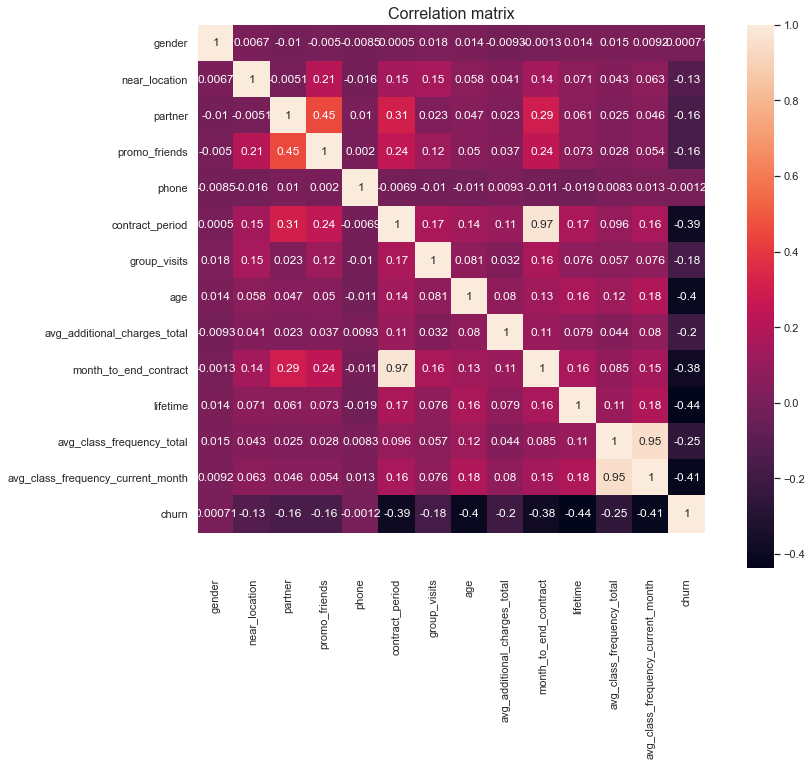

In [7]:
# getting matrix of correlation
cm = gym_churn.corr()

# printing the matrix
fig, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(cm, annot = True, square = True)
ax.set_ylim(15, 0)
plt.title('Correlation matrix', fontsize = 16)
plt.show();

We see that we have two pairs of characteristics that are highly correlated with each other: 'Avg_class_frequency_total' with 'Avg_class_frequency_current_month' and 'Contract_period' with 'Month_to_end_contract'. In the future, when building a logistic model, we will remove highly correlated columns.

**Intermediate conclusion**

So, we received data with an observation depth of 4000 lines. There are no missing data or duplicates in the data.\
We were able to collect a portrait of the average client: it can be either a man or a woman, on average 30 years old and he works or lives in the same area as the gym. In almost half of the cases, he visits the gym through an affiliate program, but only benefits from a promo from a friend in a third of cases (perhaps clients from the affiliate program cannot benefit from the promo). When choosing a contract term, the client is most often pessimistic/cautious and in more than 50% chooses a monthly contract. It is interesting that the second most popular (almost 25% of cases) is a contract for 12 months, and not for a quarter as expected (such contracts were not concluded at all).

The portrait of a client from the target group (churn = 1) according to some statistics is “shifted to the left” relative to the general portrait. Firstly, on average these are young people 27 years old, they attend group classes less often (26% vs 41%), go to the gym less often (1.47 times versus 1.88), less often take advantage of a promotion from a friend (18% vs 31%) and they have fewer additional expenses (115 vs 147). Based on this, we can make a preliminary conclusion that these are random people who have never found a company, and it’s boring to do it themselves.\
Secondly, the target group’s life time does not even reach a month (0.99 vs 3.72). I assess this as a positive sign, it is mostly newcomers, not regular customers, who leave the club. And this is another insight about the direction of the work.

OK. Let's move on to the prediction.

# Step 3. Build a model to predict user churn

First, let's create a couple of functions for convenience

In [8]:
# function for calculating MAPE
def mape (y_test, y_pred):
    y_error = y_test - y_pred
    y_error_abs = [abs(i) for i in y_error]
    perc_error_abs = y_error_abs/y_test
    mape = perc_error_abs.sum()/len(y_test)
    return mape

In [9]:
# function for printing all metrics we need
def print_all_metrics (y_true, y_pred, y_proba, title = 'Metrics'):
    print(title)
    print(f'\tAccuracy: {accuracy_score(y_true, y_pred):.2f}')
    print(f'\tPrecision: {precision_score(y_true, y_pred):.2f}')
    print(f'\tRecall: {recall_score(y_true, y_pred):.2f}')
    print(f'\tF1: {f1_score(y_true, y_pred):.2f}')
    print(f'\tROC_AUC: {roc_auc_score(y_true, y_proba):.2f}')
    #print(f'\tMAE: {mean_absolute_error(y_true, y_pred):.2f} MSE: {mean_squared_error(y_true, y_pred):.2f} MAPE: {mape(y_true, y_pred):.2f} R2: {r2_score(y_true, y_pred):.2f}')

In [10]:
# now, we will divide the set into target (Y) and independent (X) variables

X = gym_churn.drop(['contract_period','avg_class_frequency_total','churn'], axis = 1)
y = gym_churn.churn

In [11]:
# let's split the data into training and testing sets in a ratio of 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# let's standardize data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

StandardScaler()

So, I plan to train and make predictions using 3 models: Logistic regression, logistic regression with a custom threshold, and random forest.\
Why do we have 2 logistic regressions? Well, our data isn't balanced, (data where churn = 1 is about 26.5% and not 50%). Therefore, I will take on the function of God and slightly adjust the classification of responses to change the balance between Precision and Recall, and perhaps improve the model.

In [12]:
# let's start from logistic Regression
model_lr = LogisticRegression(random_state = 0)
model_lr.fit(X_train_st, y_train)
predictions = model_lr.predict(X_test_st)
probabilities = model_lr.predict_proba(X_test_st)[:,1]

LogisticRegression(random_state=0)

In [13]:
# at once, let's play it safe if the data in probabilities and y_test have different dimensions 
if probabilities.shape != y_test.shape:
    probabilities = probabilities.ravel()

In [14]:
# now, let's set a threshold
threshold = len(gym_churn.query('churn == 1'))/len(gym_churn)
custom_predictions = [0 if i < threshold else 1 for i in probabilities]

In [15]:
# and finaly, let's train the Random Forest model and get predictions
model_rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
model_rf.fit(X_train_st, y_train)
predictions_rf = model_rf.predict(X_test_st)
probabilities_rf = model_rf.predict_proba(X_test_st)[:,1]

RandomForestClassifier(random_state=0)

In [16]:
# and now let's print the all metrics to compare them
print_all_metrics(y_test, predictions, probabilities,
                  title = 'Metrcs for the predictions with predict for logistic regression')
print()
print_all_metrics(y_test, custom_predictions, probabilities,
                  title = 'Metrcs for the custom predictions with predict for logistic regression')
print()
print_all_metrics(y_test, predictions_rf, probabilities_rf,
                  title = 'Metrcs for Random Forest Classifier')
print()
print('Weights of Logistic Regression')
coefficients = model_lr.coef_[0] if len(model_lr.classes_) == 2 else model_lr.coef_
lr_df = pd.DataFrame(data = {'feature': X.columns, 'coefficients': coefficients})
lr_df['abs_coefficients'] = abs(lr_df.coefficients)
lr_df.sort_values('abs_coefficients', ascending = False)

print()
weight_0 = model_lr.intercept_
print(f'The zero coefficient is: {weight_0}')

print()
print('Weights of Random Forest')
rf_df = pd.DataFrame(data = {'feature': X.columns, 'coefficients': model_rf.feature_importances_})
rf_df.sort_values('coefficients', ascending = False)

Metrcs for the predictions with predict for logistic regression
	Accuracy: 0.91
	Precision: 0.80
	Recall: 0.82
	F1: 0.81
	ROC_AUC: 0.96
	MAE: 0.10 MSE: 0.10 MAPE: inf R2: 0.49

Metrcs for the custom predictions with predict for logistic regression
	Accuracy: 0.88
	Precision: 0.69
	Recall: 0.92
	F1: 0.79
	ROC_AUC: 0.96
	MAE: 0.12 MSE: 0.12 MAPE: inf R2: 0.36

Metrcs for Random Forest Classifier
	Accuracy: 0.91
	Precision: 0.82
	Recall: 0.78
	F1: 0.80
	ROC_AUC: 0.95
	MAE: 0.10 MSE: 0.10 MAPE: inf R2: 0.49

Weights of Logistic Regression


,feature,coefficients,abs_coefficients
9,lifetime,-3.924250,3.924250
10,avg_class_frequency_current_month,-1.334673,1.334673
8,month_to_end_contract,-1.327051,1.327051
6,age,-1.109440,1.109440
7,avg_additional_charges_total,-0.581475,0.581475
5,group_visits,-0.381252,0.381252
3,promo_friends,-0.237538,0.237538
1,near_location,-0.089490,0.089490
4,phone,-0.087079,0.087079
2,partner,-0.080828,0.080828



The zero coefficient is: [-3.86198619]

Weights of Random Forest


,feature,coefficients
9,lifetime,0.321614
10,avg_class_frequency_current_month,0.209702
6,age,0.139873
7,avg_additional_charges_total,0.124591
8,month_to_end_contract,0.116619
5,group_visits,0.019822
3,promo_friends,0.016033
2,partner,0.015954
0,gender,0.015723
1,near_location,0.011902


Before we start evaluating metrics, let's find out what is important to us.\
From the data I have, gyms have no (or negligible) retention costs. The benefit of a promotional code from a friend is offered before the contract is concluded, so this is an acquisition cost. Special conditions for clients from partner organizations - they are permanent and not caused by any measures aimed at retention. Rather, these are also acquisition costs, simply extended over time.\
Based on this, I don't care much about false positive predictions, I want to reduce false negatives. Therefore, the Recall metric will be more important for me than the Precision metric.

So, the best Recall result (0.92) was shown by the Logistic Regression model with a custom threshold. An excellent option, but we see that at the same time, the Accuracy metric decreased (to 0.88), as did the R2 metric (to 0.36) - which indicates a decrease in the interpretability of the model. This won't suit us.\
Of the remaining options, I will choose Logistic Regression, because again, its Recall indicator is higher than Random Forest, with similar other metrics.

Let's move on to the coefficients.\
Although the coefficient values of logistic regression and random forest have different interpretations (odds ratio in regression, and feature importance for the model in forest), we can use both of them for profiling.

Let's start with the logistic regression coefficients. The first thing that catches your eye is that 10 out of 11 coefficients are negative. Negative values tell us that increasing the value of the attribute reduces the chance of the target value appearing (churn = 1). Now, looking at the five strongest coefficients - we can say that the longer a client visits the gym, the more often he does it, the more months before the contract expires, the older he is, and the more additional expenses he has - the less likely he is to leave.\
By the way, the top five most important features, whose coefficients are the highest, completely repeat the top five of linear regression.


**Interimediate conclusion.**

So, we have determined by what matrices we will evaluate our models. Prepared the data, trained, and verified the results. Logistic regression turned out to be the best for us.\
We also looked at the odds and discovered that the top five strongest and most important odds coincide.


Let's see what clustering shows.

# Step 4. Create user clusters

In [17]:
# let's standardize data
scaler = StandardScaler()
x_sc = scaler.fit_transform(X)

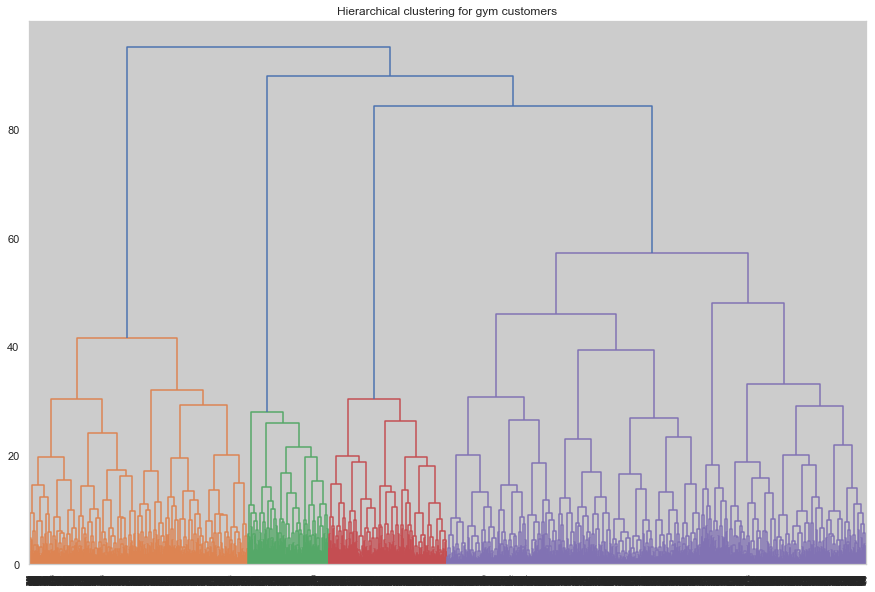

In [18]:
# let's show the dendrogram
linked = linkage(x_sc, method = 'ward')
fig, ax = plt.subplots(figsize=(15, 10))
dendrogram(linked, orientation='top', ax=ax)
plt.title('Hierarchical clustering for gym customers')
plt.show(); 

So, the dendrogram has identified four clusters for us, although I would look at the connection lower, and the cluster on the right would be divided into two.

Let's do just that, set the number of clusters = 5 and use the KMeans algorithm to divide into clusters and mark records in the data

In [19]:
# let's set the parameters and applaying the algorithm
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(x_sc)

# store the clusters label into our data
gym_churn['cluster'] = labels

In [20]:
# let's look on matrics
silhouette_avg = silhouette_score(x_sc, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.11546085235095088


A value greater than zero is already good, but I would like it to be closer to one. In our case, there will definitely be an overlap of clusters, or unclear boundaries between them.

Let's take a look at this, let's create a scatterplot. As values for X and Y, we use a couple of well-correlated features, this will facilitate perception.

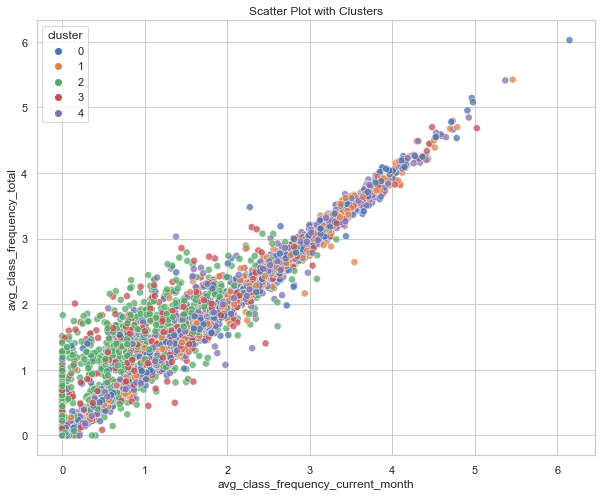

In [21]:
# let's make the scatterplot
plt.figure(figsize=(10, 8))
sns.scatterplot(y='avg_class_frequency_total', x='avg_class_frequency_current_month', hue='cluster',
                data=gym_churn, palette='deep', s=50, alpha = 0.75)
plt.title('Scatter Plot with Clusters')
plt.show();

Hmm... Perhaps the dendrogram was right, and the option with four clusters would be better, but let's continue with what we have.

In [22]:
# let's look on average values of each cluster
gym_churn_avg = gym_churn.groupby('cluster').mean()
gym_churn_avg

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.492000,0.994000,0.953000,1.000000,0.906000,7.346000,0.528000,29.633000,154.086252,6.730000,4.287000,1.960141,1.919105,0.108000
1,0.495352,0.998672,0.378486,0.046481,0.903054,5.059761,0.000000,30.342629,174.392898,4.698539,5.166003,2.240956,2.237272,0.046481
2,0.511194,1.000000,0.226368,0.114428,0.899254,1.802239,0.182836,26.807214,111.073289,1.715174,1.420398,1.327204,0.978977,0.741294
3,0.502455,0.000000,0.489362,0.072013,0.913257,2.996727,0.232406,28.700491,137.375245,2.826514,3.027823,1.768079,1.599583,0.400982
4,0.550481,0.998798,0.274038,0.075721,0.897837,5.155048,1.000000,30.248798,155.206260,4.707933,4.483173,2.068666,2.043261,0.092548


gender :


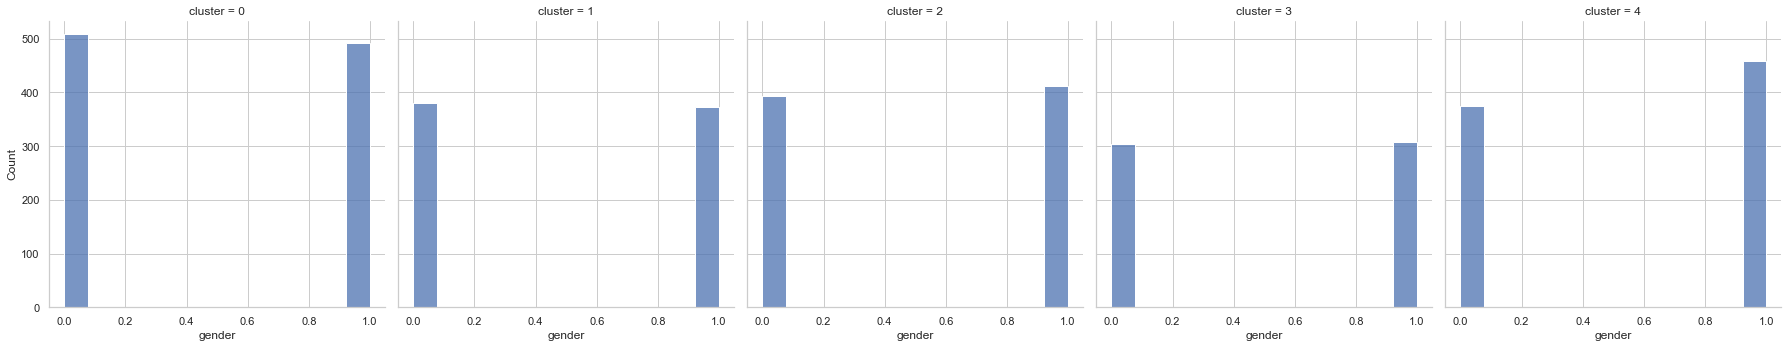

near_location :


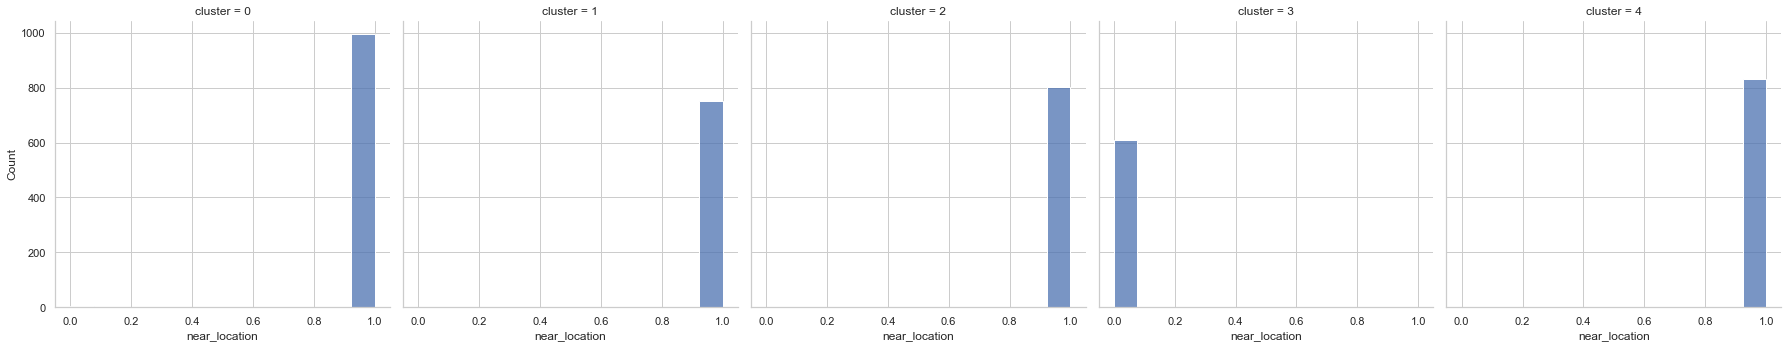

partner :


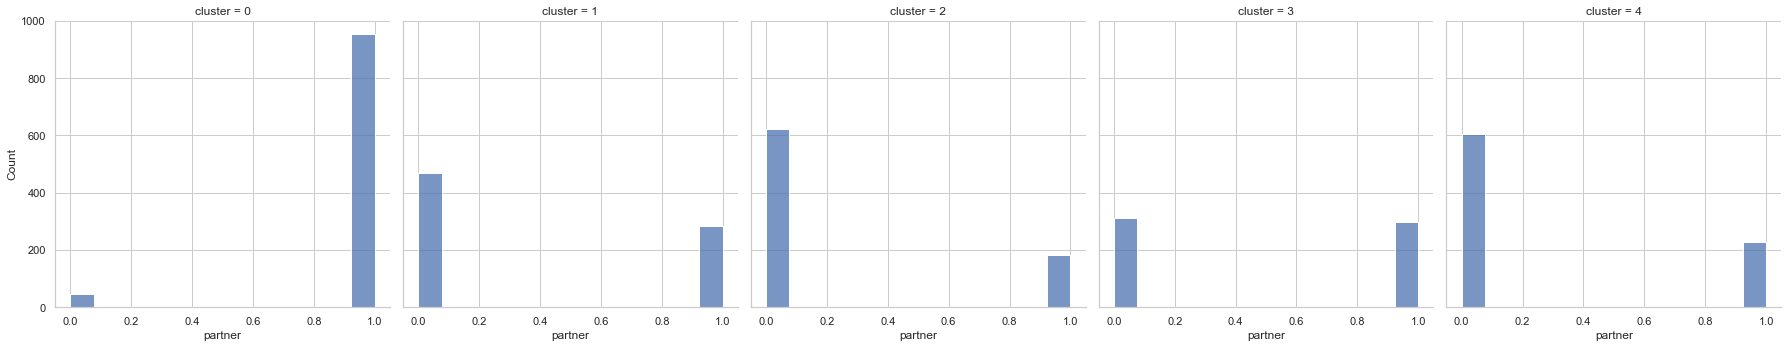

promo_friends :


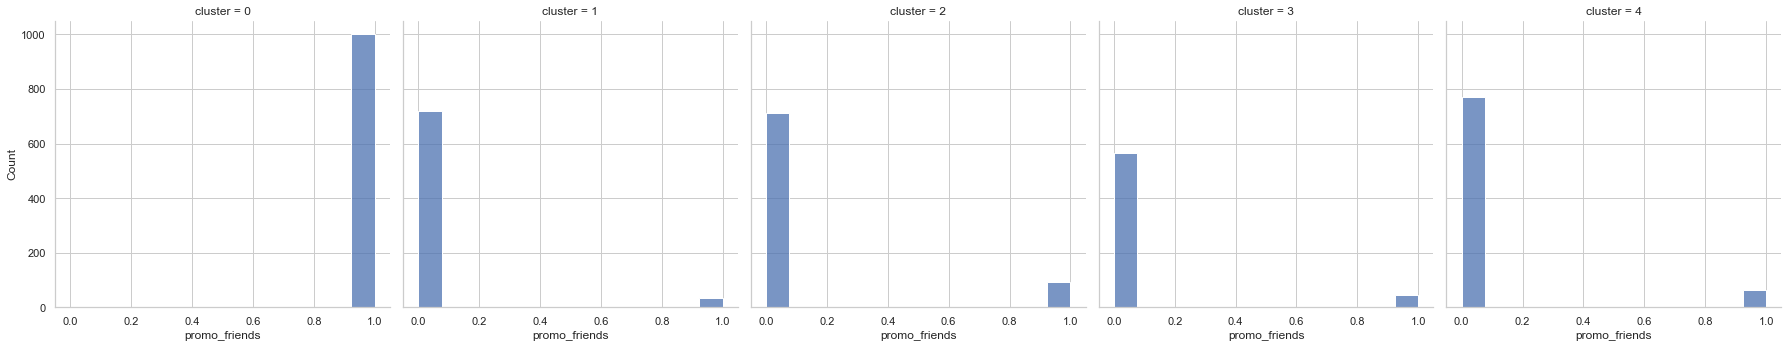

phone :


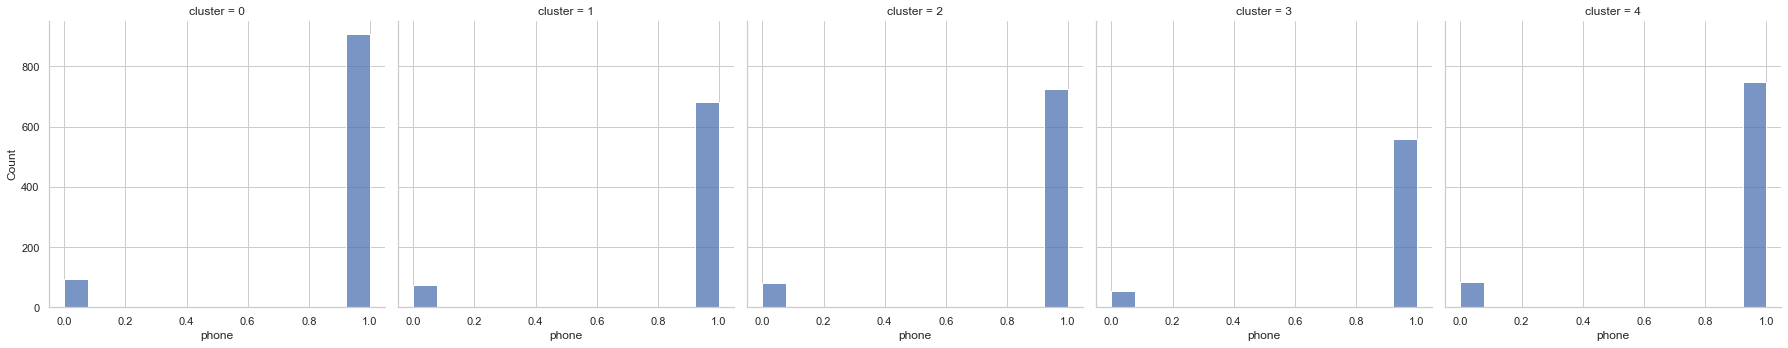

contract_period :


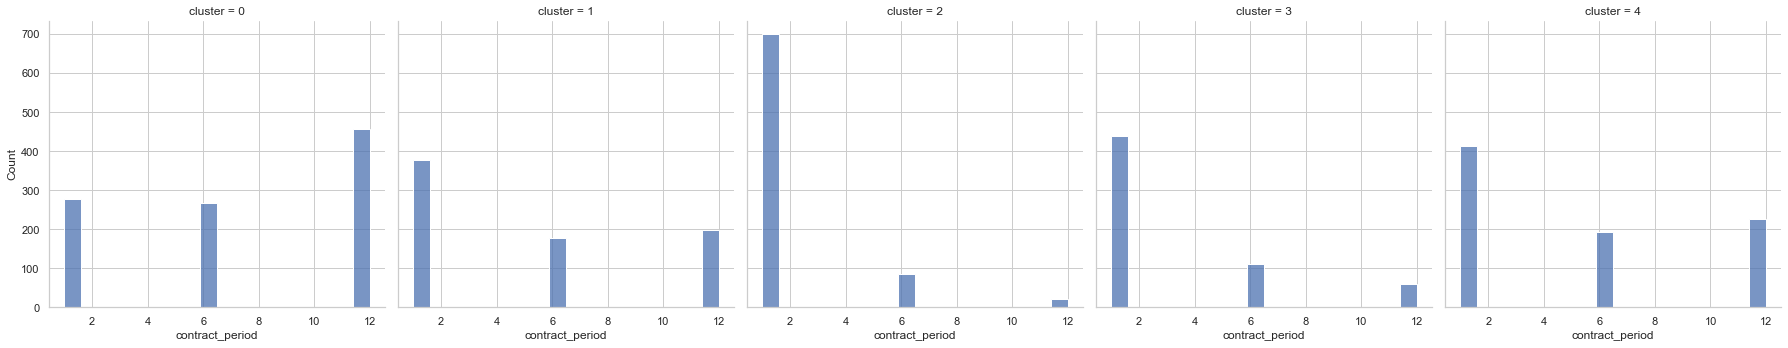

group_visits :


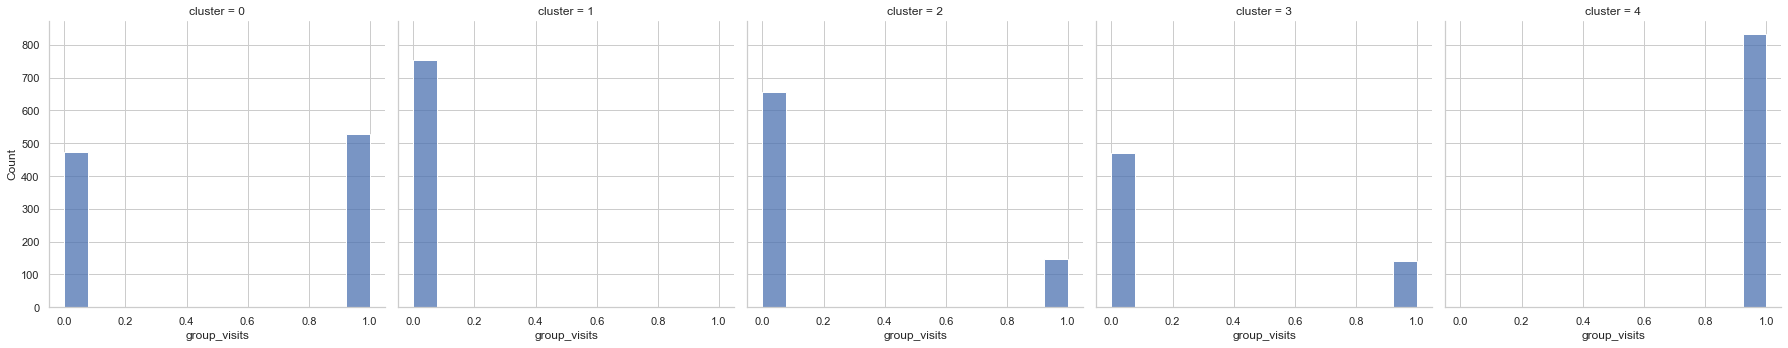

age :


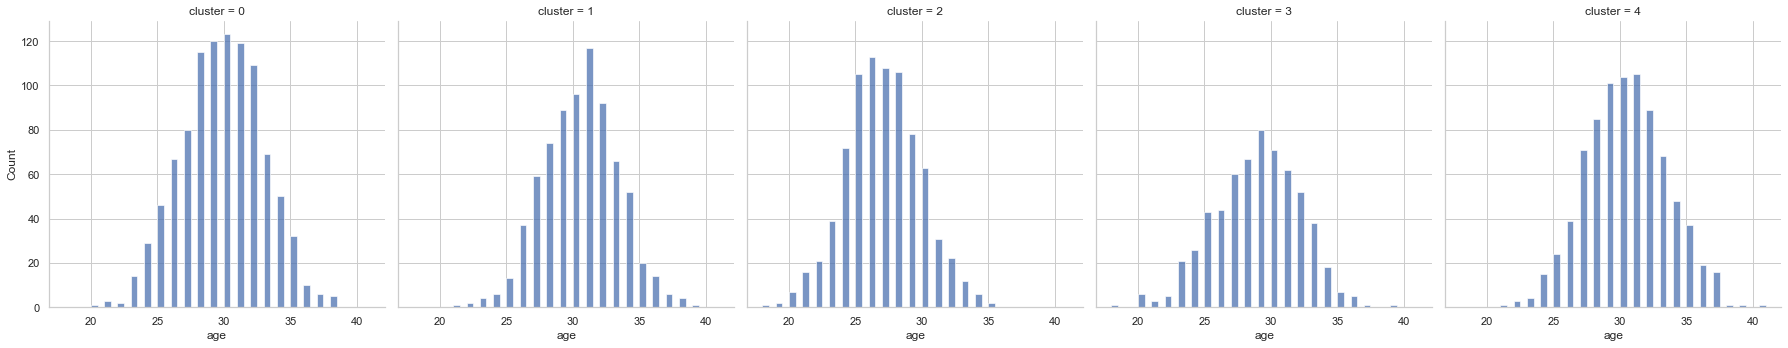

avg_additional_charges_total :


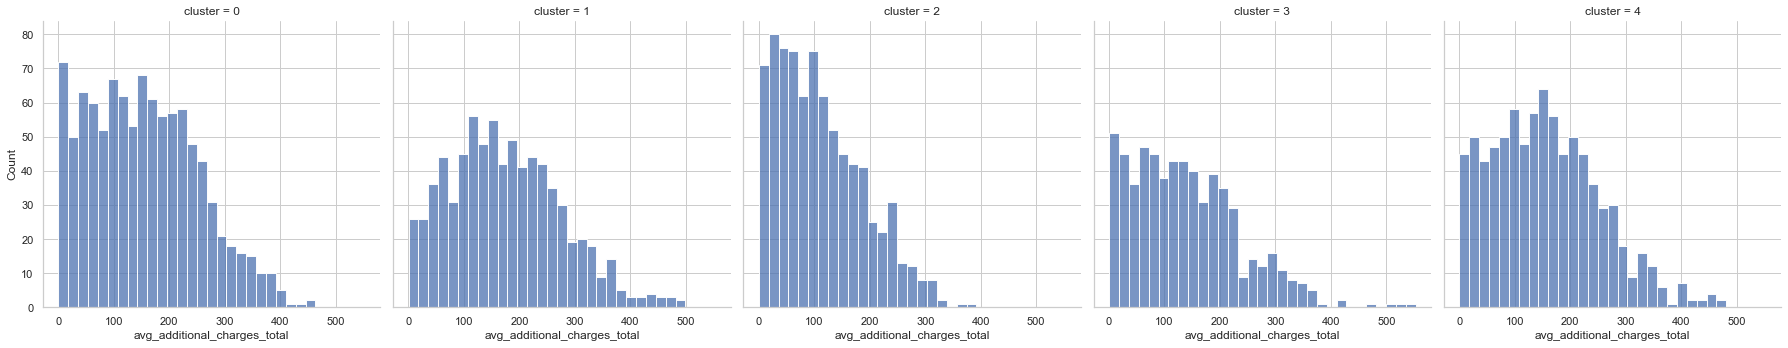

month_to_end_contract :


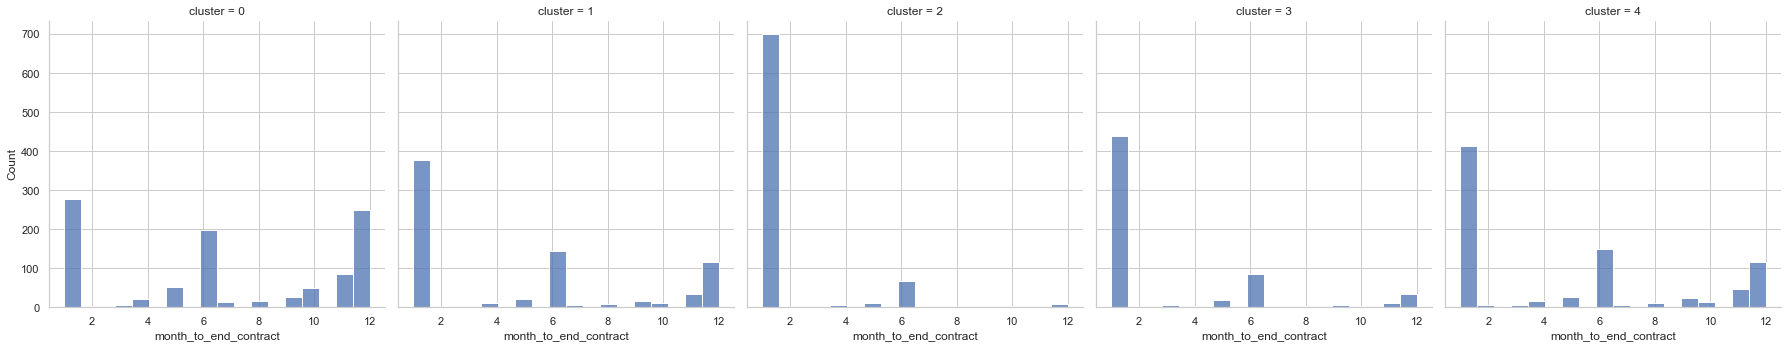

lifetime :


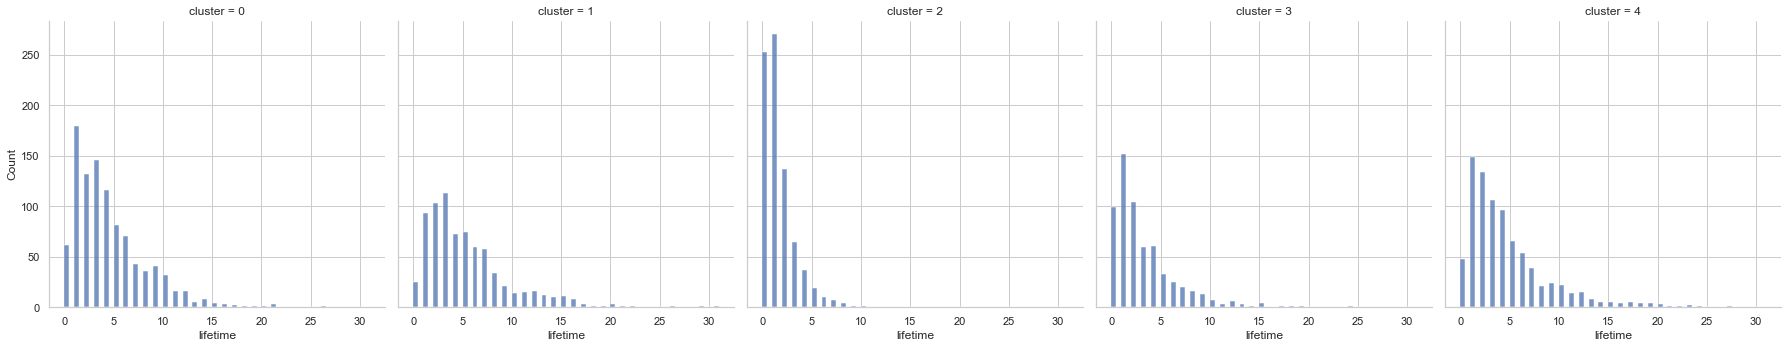

avg_class_frequency_total :


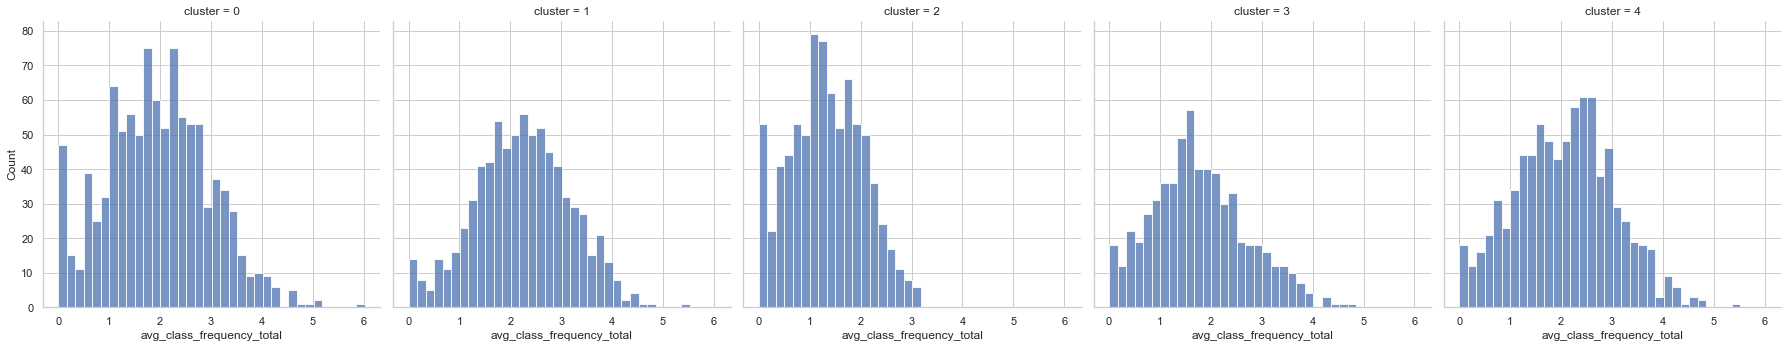

avg_class_frequency_current_month :


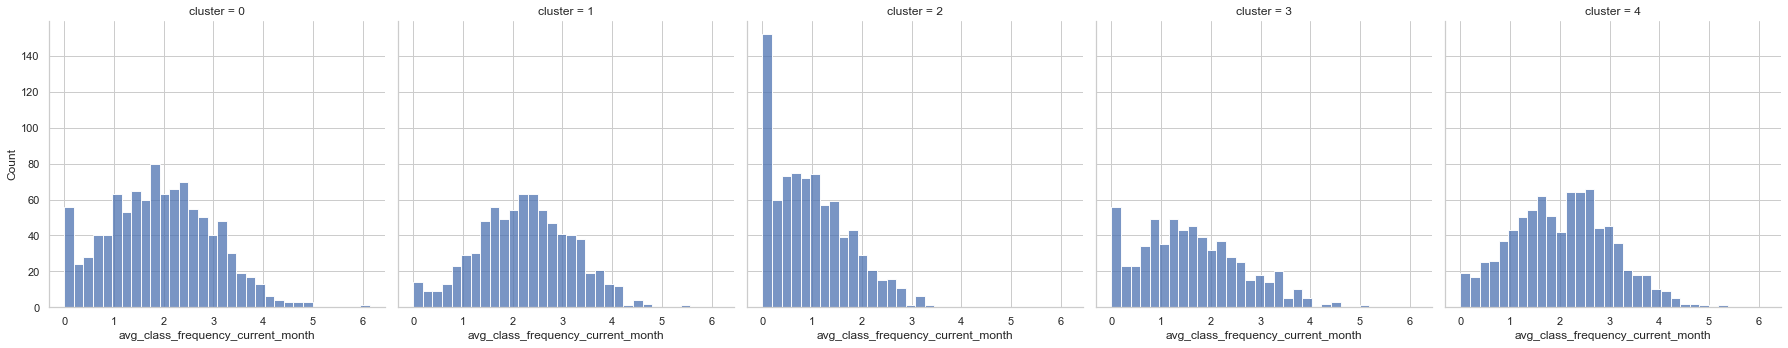

churn :


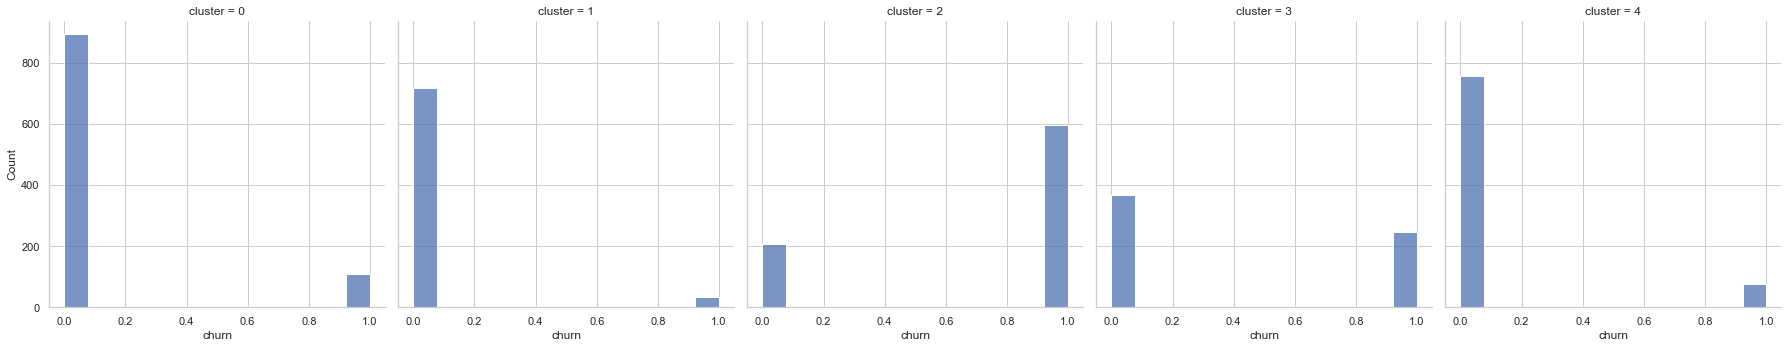

In [23]:
# vizualizating of our average data
for i in gym_churn.iloc[:,:-1].columns:
    print(i,":")
    sns.displot(data = gym_churn,x = i, col = 'cluster', palette = 'deep')
    plt.show()
plt.close('all');

In [24]:
# let's focus more detail on the feature 'churn' and make the table with the additional statistics
gym_churn_clusters = (
    gym_churn.groupby('cluster')
    .agg(churn=('churn', 'mean'), n_rows=('churn', 'count'))
    .reset_index()
    .assign(
        share_churn=lambda x: x['churn'] / x['churn'].sum()
    )
)
gym_churn_clusters.style.format({'share_churn': '{:.2%}'})

,cluster,churn,n_rows,share_churn
0,0,0.108000,1000,7.77%
1,1,0.046481,753,3.35%
2,2,0.741294,804,53.36%
3,3,0.400982,611,28.86%
4,4,0.092548,832,6.66%


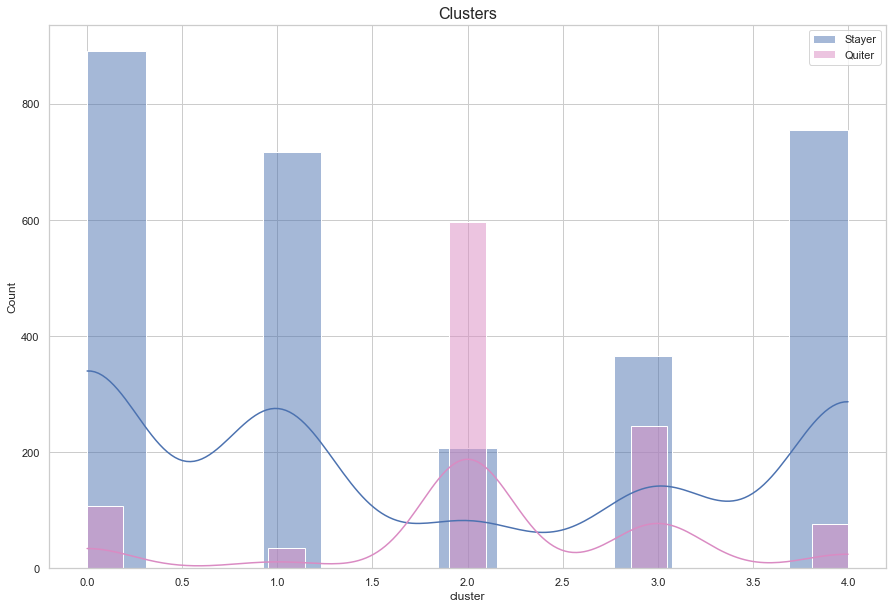

In [25]:
# and visualizing this is on the chart 
plt.figure(figsize=(15, 10))
sns.histplot(gym_churn.query('churn == 0')['cluster'], color=colors[0], kde=True, label = 'Stayer')
sns.histplot(gym_churn.query('churn == 1')['cluster'], color=colors[6], kde=True, label = 'Quiter')
plt.title('Clusters', fontsize = 16)
plt.legend()
plt.show();

So let's see what we got, but first there are few necessary declarations:
- firstly, there are no significant gender differences in the clusters. It's about 50/50, so I don't pay much attention to it further.
- secondly, speaking further about a characteristic feature relative to a cluster, I will talk about a feature with an extreme value (0 or 1) that is present in only one cluster. Such an extreme value of a characteristic is not found in any other cluster.
- thirdly, when describing clusters, average indicators for the cluster will be used.

**Cluster 0 "Consumers"** (1000 clients).\
The characteristic feature is that everyone benefits from the Promo Friend.\
**Profile:** clients are 29 - 30 years old, almost all (99%) work or live in the same area as the club, almost all (95%) came through an affiliate program. They have “long” contracts, they go 2 times a week for more than 4 months. Half (53%) attend group classes and have high additional charges. The churn index is around 10.8%\
**Summary:** the most massive group with a relatively small churn of clients, most of them are employees of partner companies (business direction) with an understandable schedule, solvent, taking advantage of all the benefits and well responsive to marketing campaigns.

**Cluster 1 "Pillars"** (753 clients)\
A characteristic feature is that they do not attend group classes at all.\
**Profile:** clients aged 30+, almost all (99%) work or live in the same area as the club, but only a little more than a third (37%) came through the affiliate program, and only 5% took advantage of Promo Friend. They also have “long contracts”, they go more than 2 times (most often) over 5 months. This cluster has the highest additional charges. Churn rate 4.6%\
**Summary:** Almost the smallest group (2nd from bottom), with the lowest churn rate, chooses an individual lesson with a trainer, which explains the highest average additional charges. These are mainly local residents (more than 60%), and the fact that they come more often and for the longest time gives the group the second name “pot of gold”.

**Cluster 2 "Local"** (804 clients)\
A characteristic feature is that they all live or work in the same area as the gym.\
**Profile:** the youngest group, average age 26-27 years. About a quarter of clients came through the affiliate program (22.6%), only every tenth (11.4%) took advantage of Promo Friend. They mainly use “short contracts” for a month; they rarely last more than 1-2 months, about once a week. This group has the lowest additional charges. Churn index 74%.\
**Summary:** judging by the fact that clients go to group classes very little, and judging by the small additional charges - they don’t work out much with a trainer, these are lonely young clients, without a strong habit of playing sports. They try to join this new community, but without proper support they quickly stop going to the gym.

**Cluster 3 "Loyalists"** (611 clients)\
A characteristic feature is that they all do not live or work in the same area as the gym.\
**Profile:** Clients aged 28-29 almost half came through an affiliate program (48%), but do not often use Promo Friend (7%). The average contract period is 3 months, but since no contracts were concluded for this period, both “short-term” and “long-term” contracts are equally well represented in the group. They last approximately the same 3 months, which means that they fulfill “long-term” contracts approximately 1-2 times a week. About a quarter (23%) attend group classes and have average additional charges. The churn rate is 40%.\
**Summary:** I see three scenarios for the emergence of such a group - the client changed housing, the client’s company changed its office, the sports club in the client’s area closed. Most likely, in the future, clients will renew short-term contracts if they are still interested in going to the sports club. But they still remain loyal, and that's worth working with.

**Cluster 4 "Community"** (832 clients)\
A characteristic feature is that they all attend group classes.\
**Profile:** clients aged 30+, almost all (99%) live or work in the area of the club, a little more than a quarter (27%) came through the affiliate program, only 7% use the benefits of Promo Friend. They use “long-term contracts”, they go for about 4.5 months more than 2 times a week. They have fairly high additional charges with a churn index of 9%.\
**Summary:** the second largest group, characteristics similar to Cluster 1 but, most of them live in the area of the gym, has twice the churn index than Cluster 1, which tells us that personal training lovers are still more motivated.

**Interimediate conclusion.**

So, using a dendrogram, we determined that we would divide the data into 5 clusters. Using the KMeans algorithm, we separated the data, received a not very large Silhouette Score value, which indicated overlap of clusters, but still continued to work with exactly this number of clusters.\
We can conditionally divide the clusters themselves into two groups: those with a large churn index value, and those with a small one.\
The group with a low churn index value includes: Cluster 1 (adult clients who prefer individual training), Cluster 4 (adult clients who prefer group training), Cluster 0 (younger people with mixed preferences).\
The group with a high churn index includes: Cluster 2 (the youngest clients who did not find themselves in the hall), Cluster 3 (older clients who moved but did not lose loyalty).

# Conclusion

So, **on this project we:**
- downloaded a file about clients, checked averages and distributions, and then created a correlation matrix.
- trained three models, selected the most suitable one and also studied the coefficients (weights).
- divided all clients into 5 clusters, looked at their characteristics and churn index values for each of them.

**What we found out:**
- The logistic regression model is best suited for prediction.
- all coefficients have a negative value, which indicates that any increase in the attribute leads to a decrease in the chance of churn (the gender coefficient is the only positive one, but is too small to have a significant impact).
- the most significant signs that affect the chance of churn in descending order: lifetime, avg_class_frequency_current_month, month_to_end_contract, age.
- high values of the same characteristics are typical for clusters with a low churn index.
- one of the main signs that is typical for clients with a high churn index is a short-term contract for 1 month, and visiting the gym once a week.

**My recommendations:**

As we remember, we have two clusters with high churn index rates, they are different from each other and the recommendations for them are different.

Clients from Cluster_two are young people living in the same area as the sports club. The main problem is a lack of involvement, a lack of understanding of why they need a gym. It might be worth creating a 3-month program that will come as a gift with a 3-month contract, which will give them the basics of gym training and add confidence. This way we will reduce the chances of churn and get working three-month contracts.\
It is also worth studying which group activities are currently popular among young people, and offering group classes.

Clients from Cluster_three are older in age, and their main problem is the distance from the gym (they do not live or work in the same area as the gym), which means large additional losses in time, and additional costs to get to the gym (from the gym to I don’t count them at home; they already had these expenses before).\
Employees should study how the visiting hours of clients from this cluster have changed, and work on the gym’s work schedule. Perhaps not every gym from the network, but one for several areas, this will reduce costs.

# Criticizing notes to the project

After completing the project, I was able to conduct a quick interview with an expert working in a chain gym, asking him to evaluate my conclusions.\
She worked not only in chain gyms with different organizational and financial models, but in several countries: Ukraine [SportLife](https://sportlife.ua/uk/) and Israel [IconFitness](https://www.iconfitness.co.il), which makes her opinions and comments meaningful to me.\
In general, they do not change the conclusion of the project, but they make the picture clearer and open up directions for search.

<div class="alert alert-info"; style="border-left: 7px solid purple">
<b>Expert's comment - 
Group visits for youth.</b>
    
Let's start from the end, you propose organizing group classes specifically for young people. But is this possible?
    
Network gyms are usually located in rented premises (in Ukraine, some gyms were built from scratch, but they were built according to different projects), which means that they vary in size, and some may simply not have space for group classes.
    
Your proposal will require “fine” tuning on the ground, and most likely sabotage, because there is no specifics.

If possible, it is better to add data on the area of gyms and group training studios to your research.
    
This is important because another important factor missed in the study is occupancy. Gyms are trying to regulate it by tying memberships to a location or time (morning, evening, all day), but with varying degrees of strictness.
    
But in vain, if a client comes and the hall is packed, all the exercise equipment and equipment are occupied, and this is not the first time - he will very quickly tune in to looking for a new gym. 
</div>
 
 
 <div class="alert alert-info"; style="border-left: 7px solid purple">
<b>Expert's comment - 
The coach is the main holding factor.</b>
    
Clients go to the gym to solve two problems: work with the body, talk it out.
    
Yes! А large percentage of clients are not going to become champions and participate in competitions, but for the company.
    
Therefore, coaches are conditionally divided into two categories: tough professionals who train champions and athletes, and, relatively speaking, psychotherapists with a sports education.
    
The first are few, the second are “workhorses”. I don’t know how to digitize, but tracking patterns and relationships is very interesting, and i think - worthy.
    
</div>


<div class="alert alert-info"; style="border-left: 7px solid purple">
<b>Expert's comment - 
Personal vs group training.</b>
    
The main problem with personal training is that clients don’t know why they are needed. They don’t know what a coach can give them, and they are simply embarrassed; most often they consider it an attempt to get more money from them.
    
An unobtrusive explanation of all the benefits and free promotional training helps, but only if the client already has an understanding of what he gets from self-training. Otherwise, there is simply no basis for comparison, and he will not appreciate it. So most often this is for experienced clients.

Group training is a little easier, especially for a beginner. On the one hand, you can get lost among everyone else, and there is no close attention from the coach (at first this confuses everyone), on the other hand, there is still a competitive element. There is an opportunity to compare yourself with others and compete. It's exciting.
    
</div>

There is a lot to think about, but overall the impression remains that our project is only a first look at the problem, a sighting shot. We have just started, and questions are already crawling out like worms after the rain.